# Corporacion Favorita Grocery Sales Forecasting

In this competition, you will be predicting the unit sales for thousands of items sold at different Favorita stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales.

### Data sets:
    1.) train[store_nbr, date, item_nbr, unit_sales]
    2.) test[store_nbr, date, item_nbr]
    3.) stores[city, state, type, cluster]
    4.) items[family, class, perishable]
    
### Notes:

- The training data does not include rows for items that had zero unit_sales for a store/date combination. There is no information as to whether or not the item was in stock for the store on the date, and teams will need to decide the best way to handle that situation. Also, there are a small number of items seen in the training data that aren't seen in the test data.


- Training data spans more than 4.5 years: from January 2013 up to mid August 2017. In contrast, the test data covers the 16 days from August 16th until August 31st.


- The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.


- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.

In [1]:
import pandas as pd
from collections import deque
from StringIO import StringIO

def get_csv_head_and_tail(filename, nr_of_rows = 2, header = 0):
    """ Read first and last n rows of a csv"""
    with open(filename, 'r') as f:
        t = deque(f, nr_of_rows)
        f.close()
        
    tail = pd.read_csv(StringIO(''.join(t)), header = None)    
    head = pd.read_csv(filename, nrows = nr_of_rows, header = header)
    
    if header is not None:
        tail.columns = head.columns
        
    return(head.append(tail))

get_csv_head_and_tail('train.csv')

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
0,125497038,2017-08-15,54,2113914,198.0,1.0
1,125497039,2017-08-15,54,2116416,2.0,0.0


In [ ]:
import pandas as pd
import numpy as np
import os

dtypes = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion': 'bool'}

# read only 2017 data
df_train = pd.read_csv('train.csv',
                       usecols=[1, 2, 3, 4, 5],
                       dtype=dtypes,
                       parse_dates=['date'],
                       converters={'unit_sales': lambda u: np.log1p(float(u)) if float(u) > 0 else 0},
                       skiprows=range(1, 101688780)).set_index(["store_nbr", "item_nbr", "date"])

df_test = pd.read_csv('test.csv',
                      usecols=[0, 1, 2, 3, 4],
                      dtype=dtypes,
                      parse_dates=["date"]).set_index(['store_nbr', 'item_nbr', 'date'])

items = pd.read_csv("items.csv").set_index("item_nbr")

stores = pd.read_csv("stores.csv").set_index("store_nbr")

In [41]:
# encode items and stores
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

items['family'] = le.fit_transform(items['family'].values)
stores['city'] = le.fit_transform(stores['city'].values)
stores['state'] = le.fit_transform(stores['state'].values)
stores['type'] = le.fit_transform(stores['type'].values)

# create onpromotion matrix with date columns for train
promo_2017_train = df_train[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)

# create onpromotion matrix with date columns for test
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)

# keep train values and fill train values which do not appear in test with 0/False
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

In [54]:
# create sale matrix with date columns
df_train = df_train[["unit_sales"]].unstack(level=-1).fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

# reindex items and stores so they fit df_train
items = items.reindex(df_train.index.get_level_values(1))
stores = stores.reindex(df_train.index.get_level_values(0))

In [90]:
# Sum sales and promo for each individual item across all stores per day
df_2017_item = df_train.groupby('item_nbr').sum()
promo_2017_item = promo_2017.groupby('item_nbr').sum()

#per store per class summary of sales
df_2017_store_class = df_train.reset_index()
df_2017_store_class['class'] = items['class'].values
df_2017_store_class_index = df_2017_store_class[['class', 'store_nbr']]
df_2017_store_class = df_2017_store_class.groupby(['class', 'store_nbr'])[df_train.columns].sum()

#per store per class summary of promotions
df_2017_promo_store_class = promo_2017.reset_index()
df_2017_promo_store_class['class'] = items['class'].values
df_2017_promo_store_class_index = df_2017_promo_store_class[['class', 'store_nbr']]
df_2017_promo_store_class = df_2017_promo_store_class.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()

In [109]:
from datetime import date, timedelta
import gc
from sklearn.metrics import mean_squared_error

def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(df, promo_df, t2017, is_train=True, name_prefix=None):
    X = {
        "promo_14_2017": get_timespan(promo_df, t2017, 14, 14).sum(axis=1).values, # total promotions past 14 days
        "promo_60_2017": get_timespan(promo_df, t2017, 60, 60).sum(axis=1).values, # total promotions past 60 days
        "promo_140_2017": get_timespan(promo_df, t2017, 140, 140).sum(axis=1).values, # total promottions past 140 days
        "promo_3_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 3).sum(axis=1).values, # total promotions 3 days ahead
        "promo_7_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 7).sum(axis=1).values, # total promotions 7 days ahead
        "promo_14_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 14).sum(axis=1).values, # total promotions 14 days ahead
    }

    for i in [3, 7, 14, 30, 60, 140]:
        tmp1 = get_timespan(df, t2017, i, i) # get sales for past i days
        tmp2 = (get_timespan(promo_df, t2017, i, i) > 0) * 1 # get promo for past i days
        
        # mean sale when there was a promotion for past i days
        X['has_promo_mean_%s' % i] = (tmp1 * tmp2.replace(0, np.nan)).mean(axis=1).values
        # decaying mean sale when there was a promotion for past i days
        X['has_promo_mean_%s_decay' % i] = (tmp1 * tmp2.replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # mean sale for no promotion for no promotion products for past i days
        X['no_promo_mean_%s' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan)).mean(axis=1).values
        # decaying mean for promotion products for past i days 
        X['no_promo_mean_%s_decay' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values # decaying mean non-promo sale products

    for i in [3, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values # mean of differenced sales for the past i days
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values # decaying mean for the past i days
        X['mean_%s' % i] = tmp.mean(axis=1).values # mean for the past i days
        X['median_%s' % i] = tmp.median(axis=1).values # median for the past i days
        X['min_%s' % i] = tmp.min(axis=1).values # min for the past i days
        X['max_%s' % i] = tmp.max(axis=1).values # max --||--
        X['std_%s' % i] = tmp.std(axis=1).values # stdev --||--

    # same as previously but starting a week before
    for i in [3, 7, 14, 30, 60, 140]: 
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values

    for i in [7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values # nr. of days product was on sale in the past i days
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values # how many days ago was the first sale
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values # how many days ago was the first sale

        tmp = get_timespan(promo_df, t2017, i, i)
        X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values # nr. of days product was on promo in the past i days
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values # how many days ago was the first sale
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values # how many days ago was the last sale
    
    # Same as before but for two weeks ahead
    tmp = get_timespan(promo_df, t2017 + timedelta(days=16), 15, 15)
    X['has_promo_days_in_after_15_days'] = (tmp > 0).sum(axis=1).values
    X['last_has_promo_day_in_after_15_days'] = i - ((tmp > 0) * np.arange(15)).max(axis=1).values
    X['first_has_promo_day_in_after_15_days'] = ((tmp > 0) * np.arange(15, 0, -1)).max(axis=1).values

    for i in range(1, 16):
        X['day_%s_2017' % i] = get_timespan(df, t2017, i, 1).values.ravel() # lag1 to lag16

    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df, t2017, 28-i, 4, freq='7D').mean(axis=1).values # past 4 dow mean
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df, t2017, 140-i, 20, freq='7D').mean(axis=1).values # past 20 dow mean

    for i in range(-16, 16):
        X["promo_{}".format(i)] = promo_df[t2017 + timedelta(days=i)].values.astype(np.uint8)

    X = pd.DataFrame(X)

    if is_train:
        y = df[pd.date_range(t2017, periods=16)]
        return X, y
    
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

In [196]:
t2017 = date(2017, 6, 14)
num_days = 6
test = []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    test.append(df_train[pd.date_range(t2017 + delta, periods=16)].columns)

In [199]:
X_val

,day_10_2017,day_11_2017,day_12_2017,day_13_2017,day_14_2017,day_15_2017,day_1_2017,day_2_2017,day_3_2017,day_4_2017,...,store_class_std_7_2,item_nbr,family,class,perishable,store_nbr,city,state,type,cluster
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,...,0.807455,96995,12,1093,0,1,18,12,3,13
1,0.000000,1.098612,1.386294,0.000000,1.098612,0.693147,0.000000,0.000000,0.000000,0.693147,...,0.633494,99197,12,1067,0,1,18,12,3,13
2,0.000000,0.693147,1.945910,1.386294,0.693147,1.098612,1.098612,1.386294,0.693147,1.386294,...,8.156398,103520,12,1028,0,1,18,12,3,13
3,0.000000,0.000000,2.197225,0.693147,1.098612,1.098612,1.386294,1.609438,0.693147,1.098612,...,4.003662,103665,5,2712,1,1,18,12,3,13
4,1.098612,1.945910,1.945910,1.386294,2.079442,1.609438,1.791759,2.197225,1.609438,1.609438,...,4.208505,105574,12,1045,0,1,18,12,3,13
5,0.693147,2.397895,2.397895,2.564949,2.772589,2.079442,2.484907,2.302585,1.945910,2.197225,...,4.208505,105575,12,1045,0,1,18,12,3,13
6,0.000000,0.000000,1.609438,0.000000,1.386294,0.000000,0.000000,1.386294,0.693147,1.386294,...,4.208505,105577,12,1045,0,1,18,12,3,13
7,0.000000,0.000000,1.098612,0.000000,0.000000,0.693147,0.693147,0.000000,0.693147,0.000000,...,12.293733,105693,12,1034,0,1,18,12,3,13
8,0.000000,1.386294,1.791759,0.000000,1.098612,0.000000,1.098612,1.386294,0.000000,0.693147,...,3.391098,105737,12,1044,0,1,18,12,3,13
9,0.693147,2.079442,1.791759,1.098612,1.791759,1.386294,0.693147,1.791759,1.098612,1.098612,...,3.426781,105857,12,1092,0,1,18,12,3,13


In [173]:
from datetime import date, timedelta
import gc
print("Preparing dataset...")

t2017 = date(2017, 6, 14)
num_days = 6
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(df_train, promo_2017, t2017 + delta)

    X_tmp2 = prepare_dataset(df_2017_item, promo_2017_item, t2017 + delta, is_train=False, name_prefix='item')
    X_tmp2.index = df_2017_item.index
    X_tmp2 = X_tmp2.reindex(df_train.index.get_level_values(1)).reset_index(drop=True)

    X_tmp3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, t2017 + delta, is_train=False, name_prefix='store_class')
    X_tmp3.index = df_2017_store_class.index
    X_tmp3 = X_tmp3.reindex(df_2017_store_class_index).reset_index(drop=True)

    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, items.reset_index(), stores.reset_index()], axis=1)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

    del X_tmp2
    gc.collect()

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

Preparing dataset...


In [177]:
# prepare validation set (same process as above)
X_val, y_val = prepare_dataset(df_train, promo_2017, date(2017, 7, 26))

X_val2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 7, 26), is_train=False, name_prefix='item')
X_val2.index = df_2017_item.index
X_val2 = X_val2.reindex(df_train.index.get_level_values(1)).reset_index(drop=True)

X_val3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 7, 26), is_train=False, name_prefix='store_class')
X_val3.index = df_2017_store_class.index
X_val3 = X_val3.reindex(df_2017_store_class_index).reset_index(drop=True)

X_val = pd.concat([X_val, X_val2, X_val3, items.reset_index(), stores.reset_index()], axis=1)


# prepare test set
X_test = prepare_dataset(df_train, promo_2017, date(2017, 8, 16), is_train=False)

X_test2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 8, 16), is_train=False, name_prefix='item')
X_test2.index = df_2017_item.index
X_test2 = X_test2.reindex(df_train.index.get_level_values(1)).reset_index(drop=True)

X_test3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 8, 16), is_train=False, name_prefix='store_class')
X_test3.index = df_2017_store_class.index
X_test3 = X_test3.reindex(df_2017_store_class_index).reset_index(drop=True)

X_test = pd.concat([X_test, X_test2, X_test3, items.reset_index(), stores.reset_index()], axis=1)

del X_test2, X_val2, df_2017_item, promo_2017_item, df_2017_store_class, df_2017_promo_store_class, df_2017_store_class_index
gc.collect()

49

In [198]:
y_val

date                2017-07-26  2017-07-27  2017-07-28  2017-07-29  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.000000    0.000000    0.693147    0.000000   
          103520      0.693147    1.098612    1.098612    1.386294   
          103665      1.609438    0.000000    1.098612    1.609438   
          105574      2.302585    1.386294    1.945910    1.386294   
          105575      1.945910    1.945910    2.397895    2.397895   
          105577      0.000000    0.000000    0.000000    1.098612   
          105693      1.098612    0.000000    0.000000    0.000000   
          105737      0.693147    0.693147    0.693147    0.693147   
          105857      2.397895    1.945910    1.386294    1.945910   
          106716      1.609438    1.945910    0.693147    0.693147   
          108079      0.693147    1.386294    0.000000    0.000000   
          108634      0.000000    0.000000    0.000000    0.000000   
          108696      0.000000    0.000000    0.000000    0.000000   
          108698      0.000000    0.693147    0.693147    0.000000   
          108701      0.693147    1.386294    2.397895    0.000000   
          108786      1.098612    1.609438    2.079442    1.609438   
          108797      1.945910    0.693147    0.693147    0.693147   
          108831      0.000000    0.000000    0.000000    0.000000   
          108862      0.000000    0.693147    0.000000    0.000000   
          108952      1.386294    0.693147    1.386294    1.098612   
          111223      1.098612    1.791759    1.791759    2.197225   
          111397      0.000000    0.000000    0.000000    0.693147   
          112830      1.098612    1.791759    2.079442    1.386294   
          114778      0.000000    1.098612    2.079442    0.000000   
          114790      1.386294    0.693147    1.098612    1.386294   
          114799      0.000000    0.000000    0.693147    1.098612   
          114800      1.386294    1.791759    1.609438    1.386294   
          115267      0.000000    0.000000    1.609438    2.397895   
          115611      2.639057    2.639057    1.945910    2.564949   
...                        ...         ...         ...         ...   
54        2081056     0.000000    1.386294    1.098612    1.386294   
          2081064     4.007333    4.007333    3.295837    3.871201   
          2081095     1.386294    1.098612    2.197225    1.386294   
          2081142     0.000000    0.000000    1.386294    0.000000   
          2081161     3.218876    2.708050    3.401197    3.367296   
          2083837     0.000000    0.000000    2.639057    0.000000   
          2083859     0.000000    0.000000    0.000000    0.000000   
          2084278     0.000000    0.693147    1.945910    0.000000   
          2084557     1.609438    1.386294    2.302585    2.944439   
          2086882     1.098612    1.609438    1.098612    1.386294   
          2087374     1.791759    1.386294    1.945910    1.386294   
          2087409     0.000000    0.693147    0.693147    0.000000   
          2087543     0.000000    0.000000    0.000000    0.000000   
          2087567     0.000000    0.000000    0.000000    0.000000   
          2087933     1.098612    0.693147    0.693147    1.098612   
          2087978     4.997212    2.079442    1.386294    1.386294   
          2088922     2.197225    0.693147    2.302585    2.302585   
          2089036     1.609438    1.945910    0.693147    1.945910   
          2089339     1.609438    2.397895    1.945910    1.791759   
          2099230     0.000000    0.000000    0.693147    0.000000   
          2101795     0.693147    0.000000    0.000000    0.693147   
          2103250     0.000000    0.000000    1.098612    1.098612   
          2105347     0.000000    1.098612    0.693147    0.000000   
          2106464     0.000000    0.693147    0.693147    0.000000   
          

In [187]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

print("Training and predicting models...")

params = {
    'num_leaves': 80,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 16
}

MAX_ROUNDS = 5000
val_pred = []
test_pred = []
cate_vars = []

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * num_days) * 0.25 + 1)
    
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    
    bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS, valid_sets=[dtrain, dval], 
                    early_stopping_rounds=125, verbose_eval=50)
    
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True)))

    val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(y_val, np.array(val_pred).transpose()))

weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose())**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

y_val = np.array(val_pred).transpose()
df_preds = pd.DataFrame(y_val, index=df_2017.index, columns=pd.date_range("2017-07-26", periods=16)).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_preds["unit_sales"] = np.clip(np.expm1(df_preds["unit_sales"]), 0, 1000)
df_preds.reset_index().to_csv('lgb_cv.csv', index=False)

print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(y_test, index=df_2017.index, columns=pd.date_range("2017-08-16", periods=16)).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb_sub.csv', float_format='%.4f', index=None)

633

In [192]:
y_train

array([[0.69314718, 0.        , 0.        , ..., 0.        , 0.        ,
        0.69314718],
       [1.38629436, 1.09861229, 0.        , ..., 1.38629436, 1.38629436,
        0.69314718],
       [1.94591015, 0.69314718, 0.69314718, ..., 1.09861229, 1.38629436,
        0.69314718],
       ...,
       [0.        , 0.        , 0.        , ..., 0.69314718, 0.        ,
        0.        ],
       [1.60943791, 0.        , 0.        , ..., 0.        , 2.07944154,
        2.30258509],
       [0.        , 0.        , 0.        , ..., 1.38629436, 0.        ,
        0.        ]])

# Time Series Forecasting

In [145]:
get_timespan(promo_2017, t2017 + timedelta(days=16), 15, 15)

date                2017-06-15  2017-06-16  2017-06-17  2017-06-18  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   
          105575         False       False       False       False   
          105577         False       False       False       False   
          105693         False       False       False       False   
          105737         False       False       False       False   
          105857         False       False       False       False   
          106716         False       False       False       False   
          108079         False       False       False       False   
          108634         False       False       False       False   
          108696         False        True       False       False   
          108698         False        True       False       False   
          108701         False       False       False       False   
          108786         False       False       False       False   
          108797          True       False       False       False   
          108831         False       False       False       False   
          108862         False       False       False       False   
          108952         False       False       False       False   
          111223         False       False       False       False   
          111397         False       False       False       False   
          112830         False       False       False       False   
          114778         False       False       False       False   
          114790          True        True        True        True   
          114799         False       False       False       False   
          114800         False       False       False       False   
          115267          True        True        True       False   
          115611         False       False       False       False   
...                        ...         ...         ...         ...   
54        2081056         True        True        True        True   
          2081064        False       False       False       False   
          2081095        False       False       False       False   
          2081142        False       False       False       False   
          2081161        False       False       False       False   
          2083837        False       False       False       False   
          2083859        False       False       False       False   
          2084278        False       False       False       False   
          2084557        False       False       False       False   
          2086882        False       False       False       False   
          2087374        False       False       False       False   
          2087409        False       False       False       False   
          2087543        False       False       False       False   
          2087567        False       False       False       False   
          2087933        False       False       False       False   
          2087978        False       False       False       False   
          2088922        False       False       False       False   
          2089036        False       False       False       False   
          2089339        False       False       False       False   
          2099230        False        True       False       False   
          2101795        False       False        True       False   
          2103250        False       False       False       False   
          2105347         True        True        True       False   
          2106464        False       False        True        True   
          

    1.) Understand the type of time series
    2.) Establish a prediction baseline
    3.) Build a prediction model
    4.) Validate model using walk-forward validation

### 1.) Predict overall weekly sales

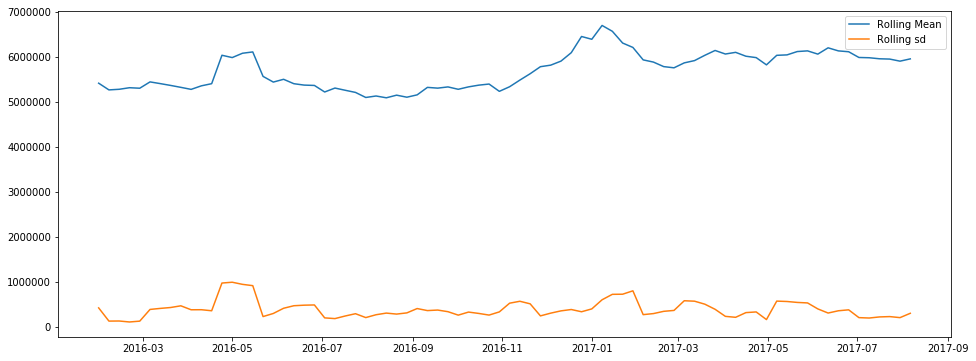

In [41]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=4, center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=4, center=False).std(),label='Rolling sd');
plt.legend()

In [24]:
unique_stores = list(train['store_nbr'].unique())
unique_items = list(train['item_nbr'].unique())

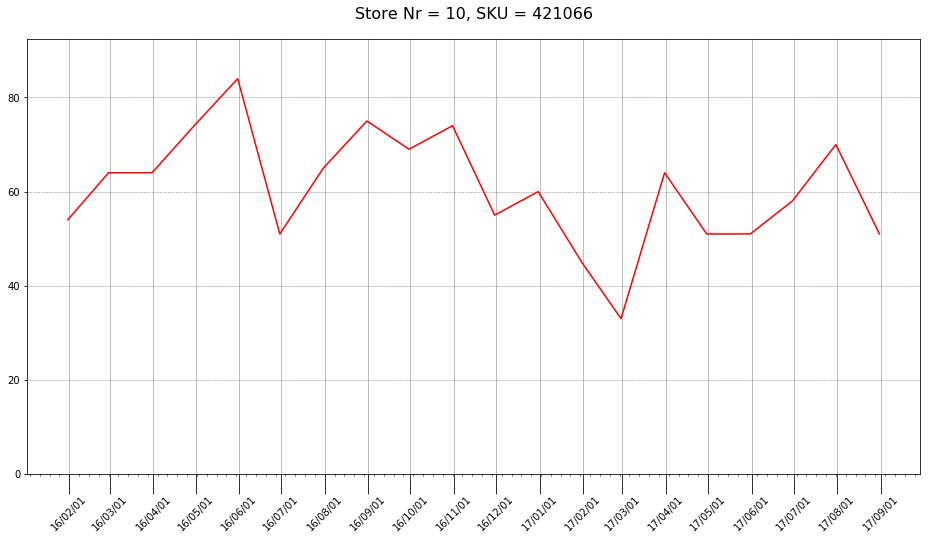

In [67]:
import matplotlib as mpl
from matplotlib.dates import WeekdayLocator, YearLocator, MonthLocator, DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

def plot_sales(storeNr, itemNr):
    x = train[(train['store_nbr'] == storeNr) & (train['item_nbr'] == itemNr)].groupby(['date'])['unit_sales'].sum().resample('M').sum().index
    y = train[(train['store_nbr'] == storeNr) & (train['item_nbr'] == itemNr)].groupby(['date'])['unit_sales'].sum().resample('M').sum().values

    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.set_title('Store Nr = {}, SKU = {}'.format(storeNr, itemNr), pad = 20, fontdict = {'fontsize': 16})
    ax.plot_date(mpl.dates.date2num(x), y, 'r-')
    ax.set_ylim(0, max(y)*1.1)
#     ax.set_xlim(x[0], x[-1])
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%y/%m/%d'))
    ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=MO))
    ax.tick_params(axis = 'x', which = 'major', direction = 'out', length = 20, pad = 0, labelrotation = 45)
    ax.tick_params(axis = 'x', which = 'minor')
    ax.grid(axis = 'x', which = 'major', color='k', linestyle='-', linewidth=0.5, alpha=0.5)
    ax.grid(axis = 'y', which = 'major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()
    
plot_sales(storeNr = 10, itemNr = 421066)

## Time Series as Supervised Learning

### 1.) Sliding window method

In [3]:
# ts is total sale for all stores all products
ts = train.groupby(['date'])['unit_sales'].sum().resample('W').sum()

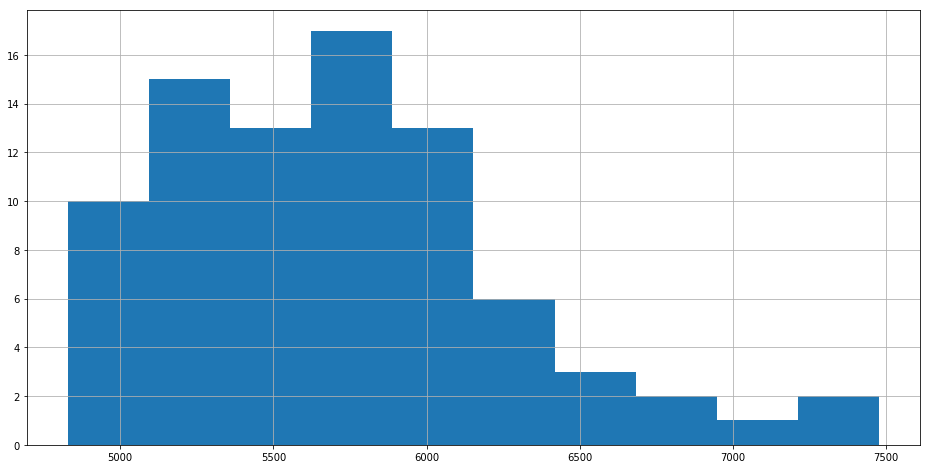

In [226]:
ts_df['t+1'].hist(figsize = (16, 8))
plt.show()

In [209]:
X = ts_df['t+1'].values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%.2f, mean2=%.2f' % (mean1, mean2))
print('variance1=%.2f, variance2=%.2f' % (var1, var2))

mean1=5367.33, mean2=6039.73
variance1=208415.24, variance2=182617.54


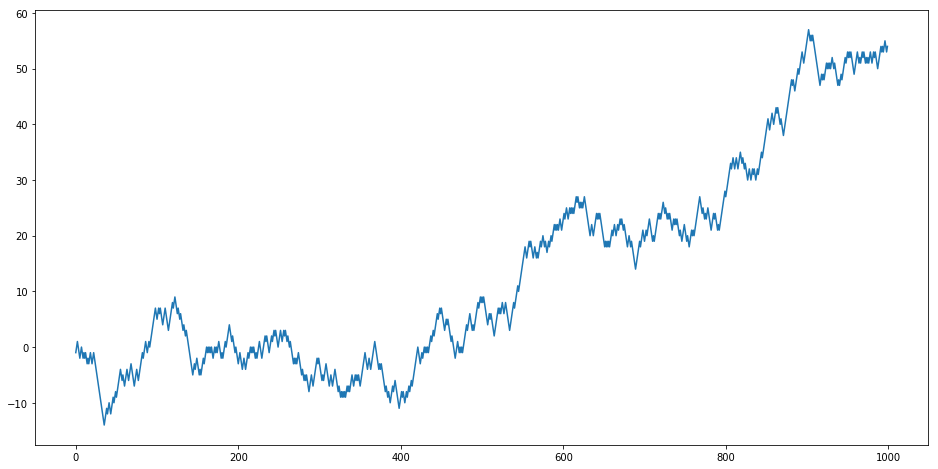

In [129]:
# Random walk
from random import seed
from random import random

seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

plt.figure(figsize=(16, 8))
plt.plot(random_walk)
plt.show()

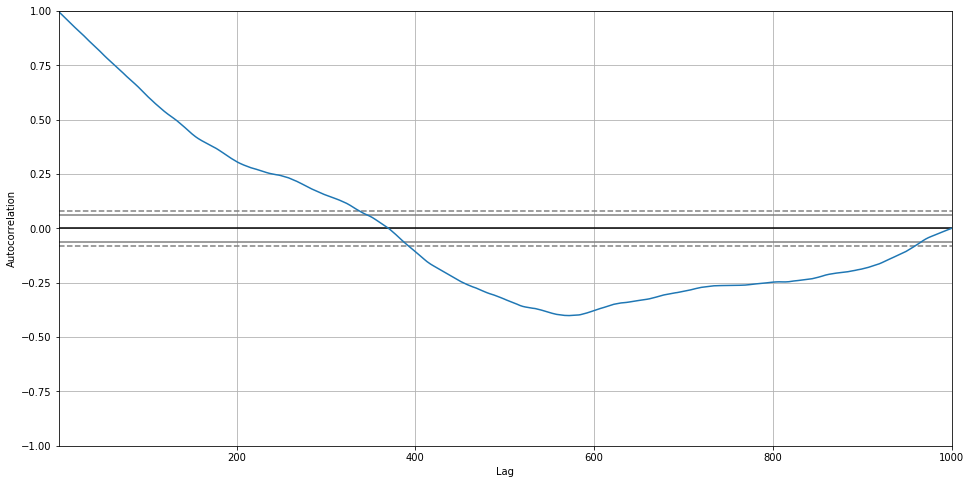

In [130]:
# plot the autocorrelation of a random walk
from random import seed
from random import random

from pandas.plotting import autocorrelation_plot

seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)


plt.figure(figsize=(16, 8))
autocorrelation_plot(random_walk)
plt.show()

In [132]:
from random import seed
from random import random
from statsmodels.tsa.stattools import adfuller

# generate random walk
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

# statistical test
result = adfuller(random_walk)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.341605
p-value: 0.979175
Critical Values:
	5%: -2.864
	1%: -3.437
	10%: -2.568


### Time Series Decomposition

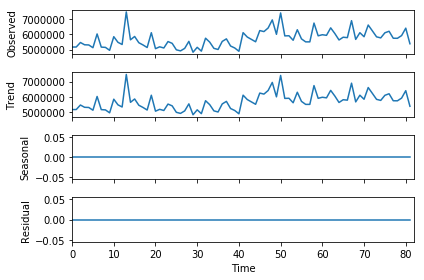

In [191]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
series = np.array(ts_df['t+1'])
result = seasonal_decompose(series, model='additive', freq = 1)
result.plot()
plt.show()

### Removing trend

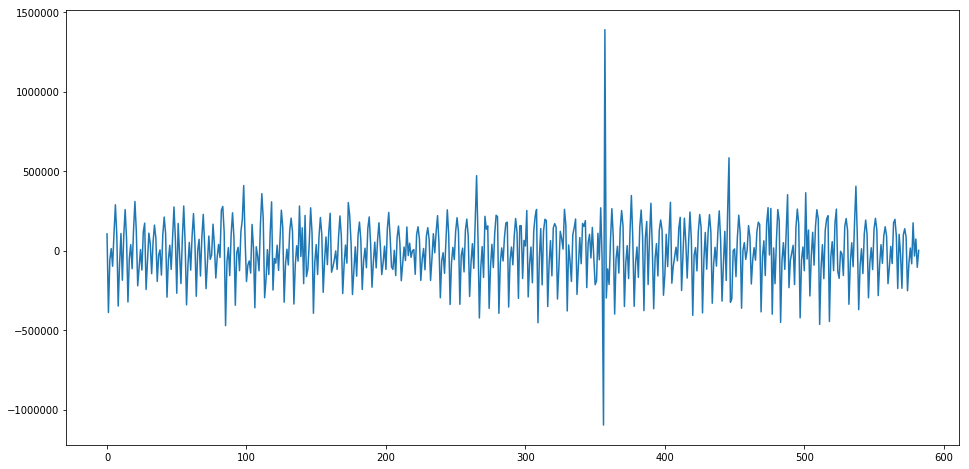

In [148]:
from pandas import datetime

X = ts_df['t+1'].values
diff = list()

for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
    
plt.figure(figsize=(16, 8))
plt.plot(diff)
plt.show()

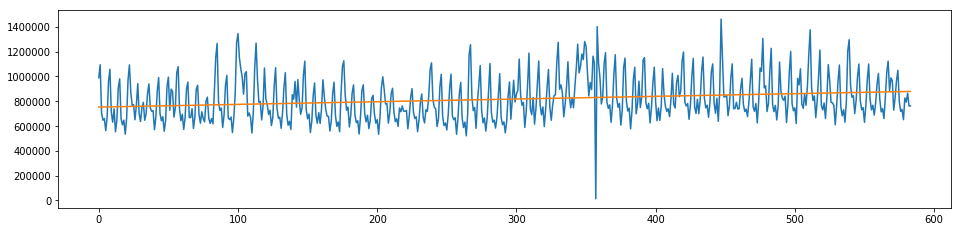

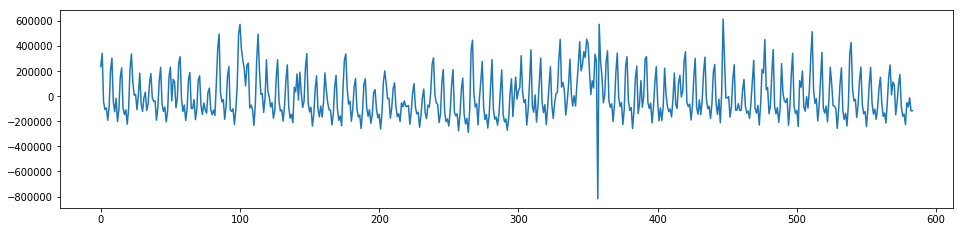

In [147]:
from sklearn.linear_model import LinearRegression
import numpy


# fit linear model
X = [i for i in range(0, len(ts_df['t+1']))]
X = numpy.reshape(X, (len(X), 1))
y = ts_df['t+1'].values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.figure(figsize=(16, 8))
plt.subplot(211)
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(ts_df['t+1']))]
# plot detrended
plt.figure(figsize=(16, 8))
plt.subplot(212)
plt.plot(detrended)
plt.show()

### Removing Seasonality

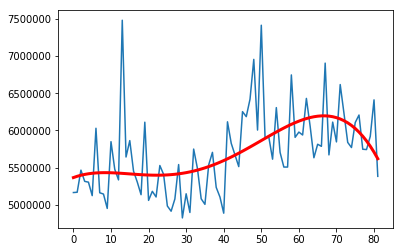

In [192]:
from numpy import polyfit

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(ts_df['t+1']))]
y = ts_df['t+1'].values

degree = 4
coef = polyfit(X, y, degree)

curve = list()

for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(ts_df['t+1'].values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

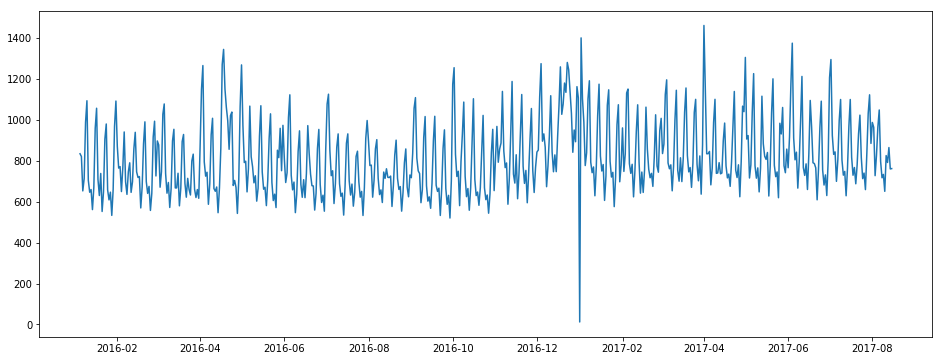

In [235]:
plt.figure(figsize = (16, 6))
plt.plot(ts_df['t+1'])
plt.show()

In [411]:
def calc_stock(series):
    stock = []
    init = series.rolling(window = 15).sum().dropna()[0]
    
    for index, value in enumerate(series):
        if init - value > 20:
            s = init - value
            stock.append(s)
        else:
            s += series.rolling(window = 15).sum().dropna()[0]
            stock.append(s)
        init = s
    return stock

stock = calc_stock(ts)

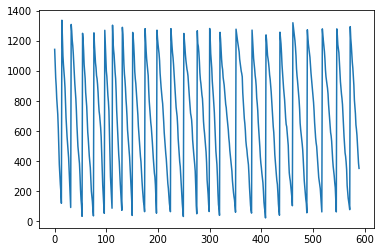

In [412]:
plt.plot(stock)
plt.show()

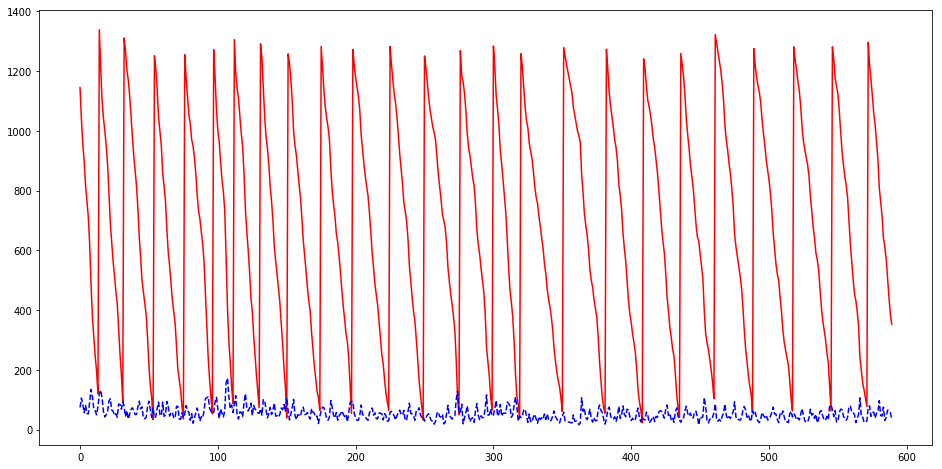

In [413]:
plt.figure(figsize = (16, 8))
plt.plot(stock, 'r-')
plt.plot(ts.values, 'b--')
plt.show()

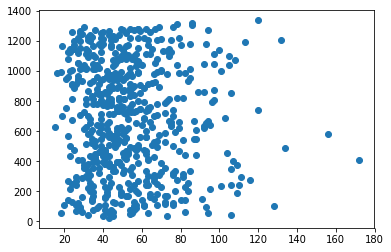

In [415]:
plt.scatter(ts.values, stock)
plt.show()

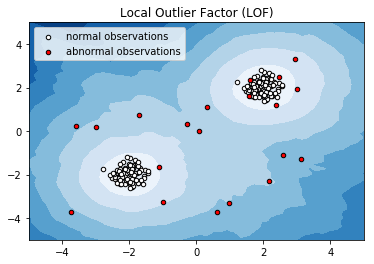

In [416]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X = 0.3 * np.random.randn(100, 2)
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X + 2, X - 2, X_outliers]

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[200:]

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Local Outlier Factor (LOF)")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

a = plt.scatter(X[:200, 0], X[:200, 1], c='white',
                edgecolor='k', s=20)
b = plt.scatter(X[200:, 0], X[200:, 1], c='red',
                edgecolor='k', s=20)
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a, b],
           ["normal observations",
            "abnormal observations"],
           loc="upper left")
plt.show()

In [514]:
data = ts.to_frame(name = 'sales')
data['stock'] = stock

import random

def insert_random_outlier(df, nr_of_indices, col_nr):
    index = []
    random.seed(7)
    for i in range(nr_of_indices):
        index.append(random.randrange(0, len(df)-1, 1))
    
    for i in index:
        df.iloc[i, col_nr] = 0
        
    return df

test = insert_random_outlier(data, 10, 0)

In [518]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(test.values)

## 2.) Forecasting sales for a single product

    1.) Data processing
    2.) Time series analysis
    3.) Prediction baseline
    4.) Prediction models
    5.) Walk-forward validation

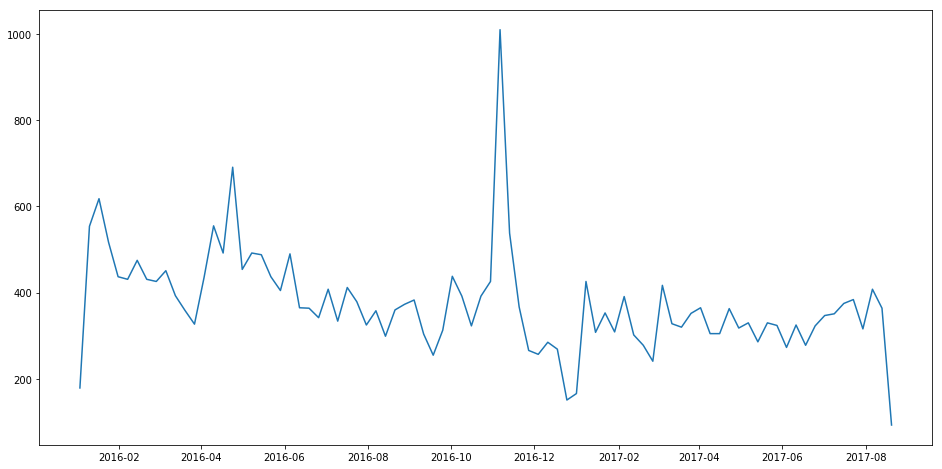

In [640]:
import pandas as np
import numpy as np
import matplotlib.pyplot as plt

def get_sales(df, storeNr, itemNr):
    x = df[(df['store_nbr'] == storeNr) & (df['item_nbr'] == itemNr)].groupby(['date'])['unit_sales'].sum()
    return x

ts = get_sales(train, storeNr = 44, itemNr = 1146795)

plt.figure(figsize=(16, 8))
plt.plot(ts)
plt.show()

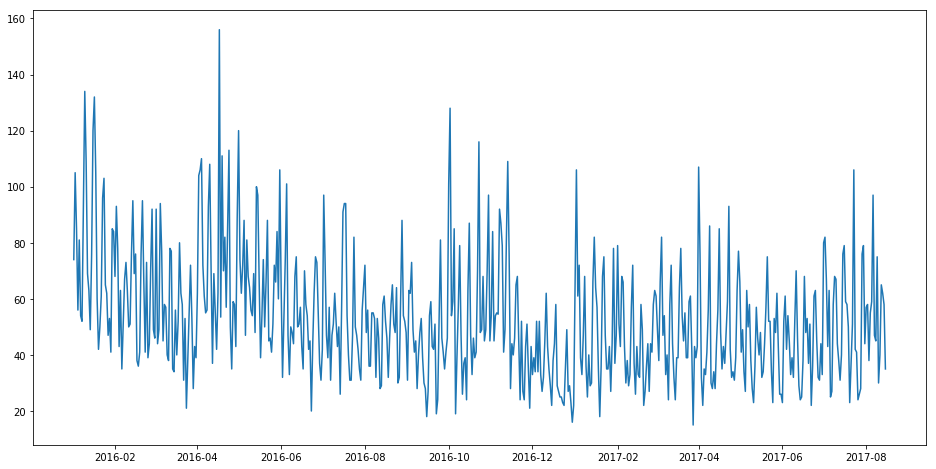

In [642]:
# take out outlier
ts[ts == max(ts)] = np.mean(ts)

plt.figure(figsize=(16, 8))
plt.plot(ts)

plt.show()

### 2.) Time series analisys

<Figure size 432x288 with 0 Axes>

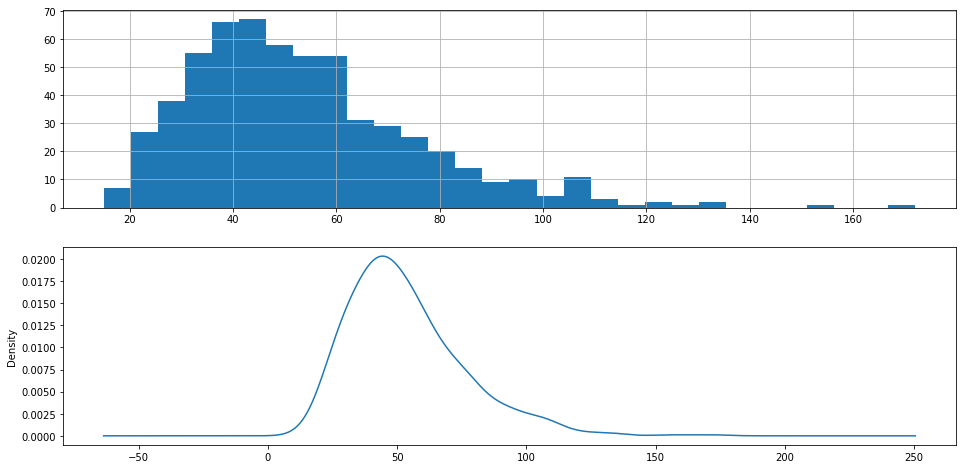

In [597]:
plt.figure(1)
plt.figure(figsize = (16, 8))
plt.subplot(211)
ts.hist(bins = 30)
plt.subplot(212)
ts.plot(kind='kde')
plt.show()

In [564]:
from statsmodels.tsa.stattools import adfuller

# Stationarity test
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -3.699974
p-value                          0.004114
#Lags Used                      18.000000
Number of Observations Used    571.000000
Critical Value (5%)             -2.866615
Critical Value (1%)             -3.441854
Critical Value (10%)            -2.569473
dtype: float64


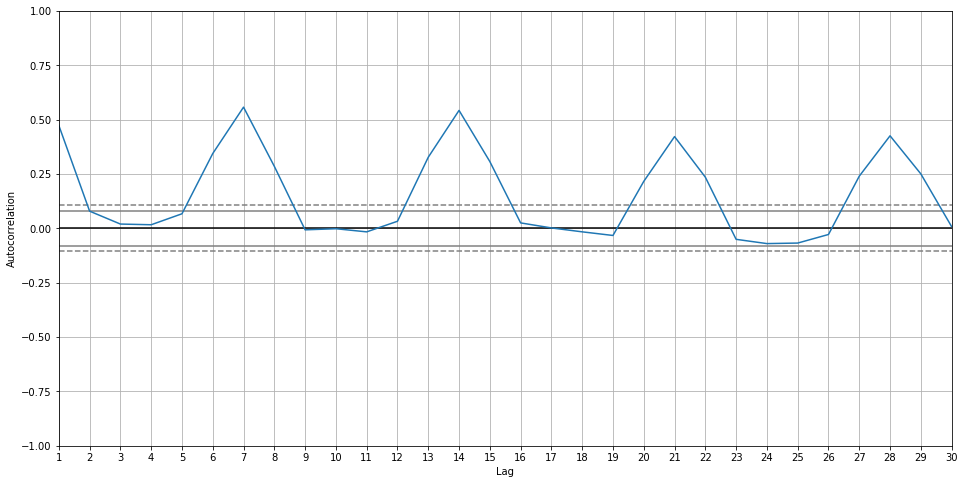

In [562]:
from pandas.plotting import autocorrelation_plot

xmin, xmax = 1, 30
ticks = range(1, xmax+1, 1)

plt.figure(figsize=(16, 8))
autocorrelation_plot(ts)
plt.xlim((xmin, xmax))
plt.xticks(ticks, ticks)
plt.show()

In [565]:
ts_df = ts.to_frame(name = 't+1')
ts_df['t'] = ts_df['t+1'].shift(periods = 1)
ts_df['t-7'] = ts_df['t+1'].shift(periods = 7)
ts_df['t-14'] = ts_df['t+1'].shift(periods = 14)
ts_df['t-21'] = ts_df['t+1'].shift(periods = 21)
ts_df['t-28'] = ts_df['t+1'].shift(periods = 28)
# ts_df['t-35'] = ts_df['t+1'].shift(periods = 35)
# ts_df['t-42'] = ts_df['t+1'].shift(periods = 42)
# ts_df['t-49'] = ts_df['t+1'].shift(periods = 49)
# ts_df['t-56'] = ts_df['t+1'].shift(periods = 56)

ts_df.dropna(inplace = True)
# ts_df.drop(ts_df.index[0], inplace = True)
# ts_df.drop(ts_df.index[-1], inplace = True)

ts_df.head()

,t+1,t,t-7,t-14,t-21,t-28
date,,,,,,
2016-01-30,85.0,41.0,96.0,120.0,92.0,74.0
2016-01-31,84.0,85.0,103.0,132.0,134.0,105.0
2016-02-01,68.0,84.0,65.0,105.0,109.0,85.0
2016-02-02,93.0,68.0,62.0,60.0,69.0,56.0
2016-02-03,78.0,93.0,47.0,42.0,63.0,81.0


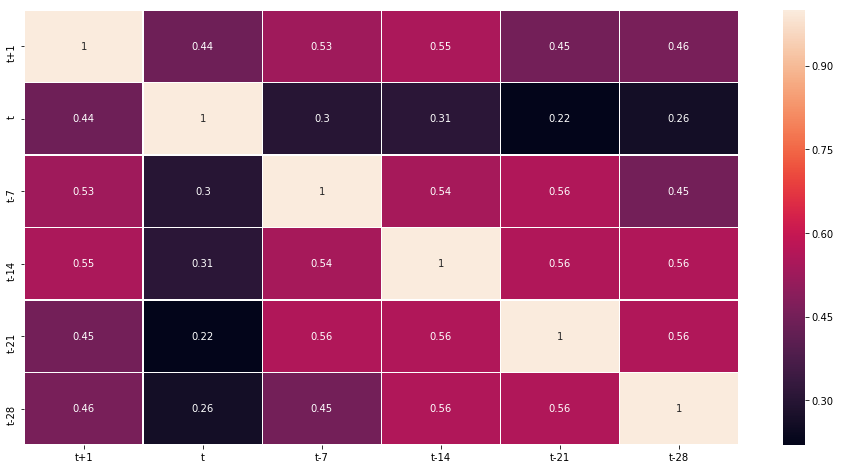

In [566]:
import seaborn as sns
corr = ts_df.corr().round(decimals = 2)

fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, linewidths=.5)
plt.show()

### 3.) Prediction baseline

Before diving into modeling an important step is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

In [571]:
### Split data in train and test set (test ~ 10%)
split = len(ts) - 60
ts_train, X_test = ts[:split], ts[split:]

# Further split train into train and validation
train_size = int(len(ts) * 0.70)
X_train, X_validation = ts_train[:train_size], ts_train[train_size:]

 The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

In [589]:
# Use persistance model as a baseline
history = list(X_train)
predictions = list()

# Persistance model
for i in range(len(X_validation)):
    
    # Predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # Add observation
    obs = X_validation[i]
    history.append(obs)

# Report performance 
rmse = sqrt(mean_squared_error(X_validation, predictions))
print('Baseline validation RMSE: %.3f' % rmse)

Baseline validation RMSE: 19.044


Baseline could be improved by correcting forecasts with a model of forecast residual errors 

### 4.) Prediction baseline

Test RMSE: 245.718


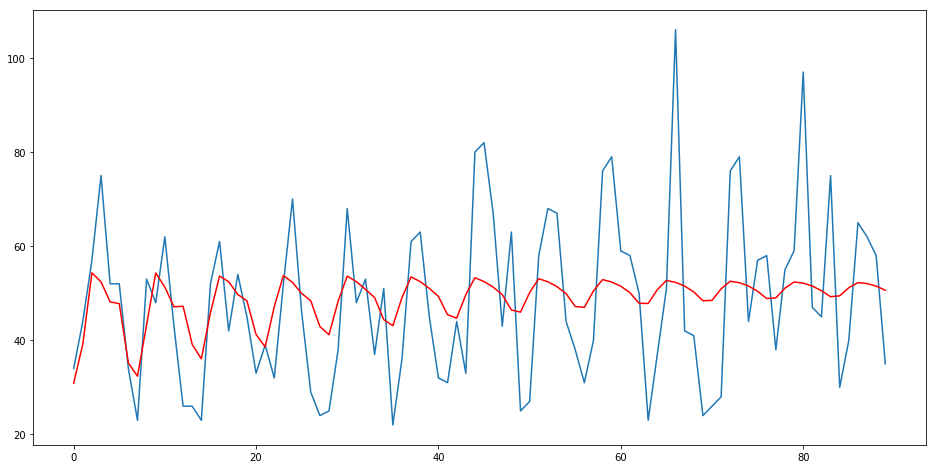

In [240]:
from statsmodels.tsa.ar_model import AR 
from sklearn.metrics import mean_squared_error 
from math import sqrt 

model = AR(train) 
model_fit = model.fit() 
# print('Lag: %s' % model_fit.k_ar) 
# print('Coefficients: %s' % model_fit.params) 

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 
# for i in range(len(predictions)): 
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))

rmse = mean_squared_error(test, predictions) 
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (16, 8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Test RMSE: 13.146


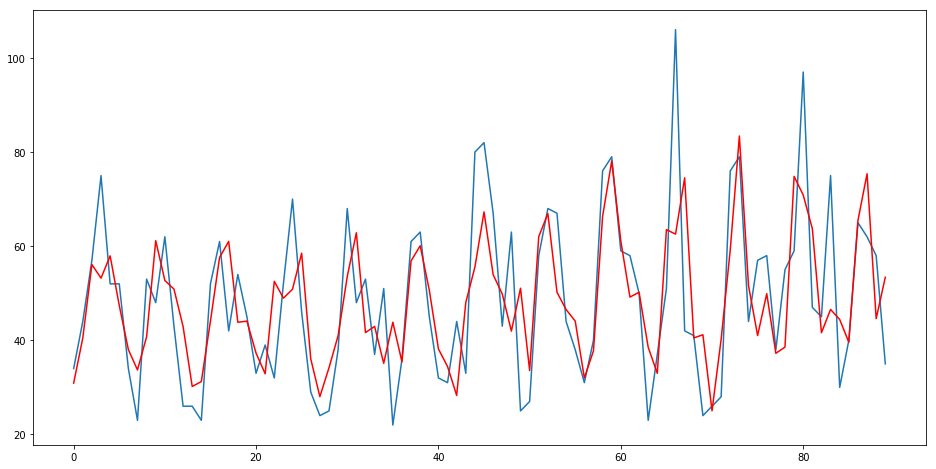

In [246]:
model = AR(train) 
model_fit = model.fit() 
window = model_fit.k_ar 
coef = model_fit.params

# walk forward over time steps in test 
history = train[len(train)-window:] 
history = [history[i] for i in range(len(history))] 
predictions = list() 

for t in range(len(test)): 
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    
    for d in range(window): 
        yhat += coef[d+1] * lag[window-d-1] 
        
    obs = test[t]
    predictions.append(yhat) 
    history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (16, 8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

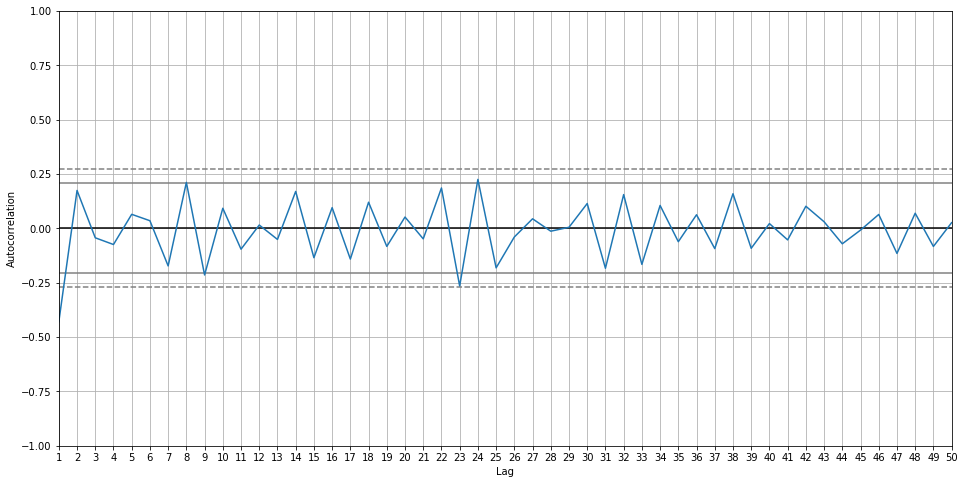

In [233]:
error = test-predictions

xmin, xmax = 1, 50
ticks = range(1, xmax+1, 1)

plt.figure(figsize=(16, 8))
autocorrelation_plot(error)
plt.xlim((xmin, xmax))
plt.xticks(ticks, ticks)
plt.show()

In [278]:
train_size = int(len(ts) * 0.80)
y_train, y_test = ts_df['t+1'].iloc[:train_size].values, ts_df['t+1'].iloc[train_size:].values
X_train, X_test  = ts_df.iloc[:train_size, 1:].values, ts_df.iloc[train_size:, 1:].values

In [295]:
# Load libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor(n_neighbors = 10)))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))
models.append(('ADA', AdaBoostRegressor()))
models.append(('SVR', SVR()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    splits = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=splits, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -310.649025 (233.599004)
LASSO: -308.418122 (229.020525)
EN: -309.248280 (230.664444)
KNN: -262.971443 (97.051903)
CART: -610.313077 (330.883423)
RF: -292.934747 (88.554664)
ET: -302.194990 (83.293656)
ADA: -347.840061 (228.119390)
SVR: -394.565763 (106.953945)


Test RMSE: 13.272


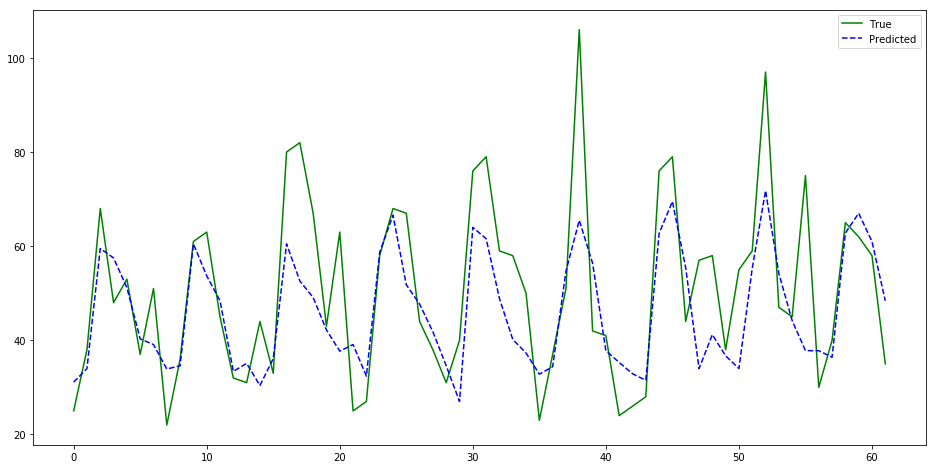

In [297]:
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_hat))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (16, 8))
plt.plot(y_test, 'g-')
plt.plot(y_hat, 'b--')
plt.legend(['True', 'Predicted'])
plt.show()

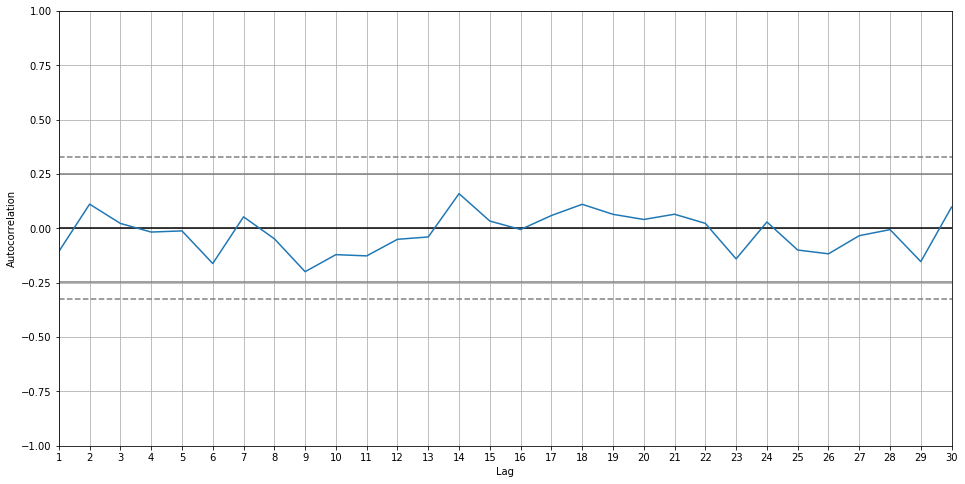

In [298]:
error = y_test - y_hat

xmin, xmax = 1, 30
ticks = range(1, xmax+1, 1)

plt.figure(figsize=(16, 8))
autocorrelation_plot(error)
plt.xlim((xmin, xmax))
plt.xticks(ticks, ticks)
plt.show()

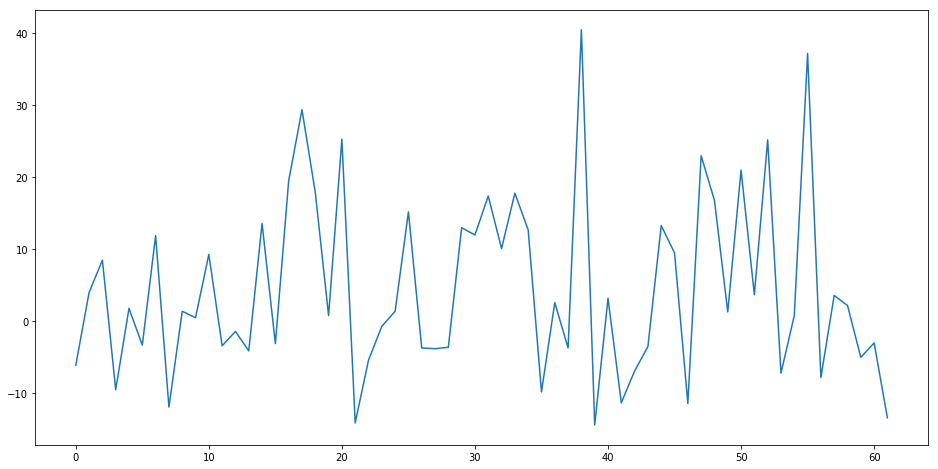

In [299]:
plt.figure(figsize=(16, 8))
plt.plot(error)
plt.show()

Test RMSE: 12.962


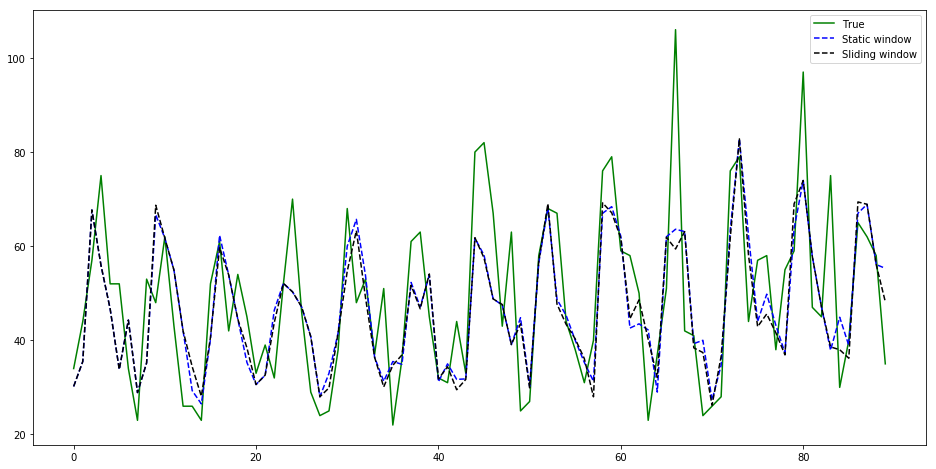

In [271]:
# Expanding window
n_train = int(len(ts) * 0.80)
n_records = len(ts_df['t+1'])

y_hat_sw = []
model = KNeighborsRegressor(n_neighbors = 10)

for i in range(n_train, n_records):
    X_train, y_train = ts_df.iloc[:i, 1:], ts_df['t+1'].iloc[:i]
    X_test = ts_df.iloc[i:i+1, 1:]
    
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    y_hat_sw.append(prediction)
    
rmse = sqrt(mean_squared_error(y_test, y_hat_sw))
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (16, 8))
plt.plot(y_test, 'g-')
plt.plot(y_hat, 'b--')
plt.plot(y_hat_sw, 'k--')
plt.legend(['True', 'Static window', 'Sliding window'])
plt.show()

Test RMSE: 12.690


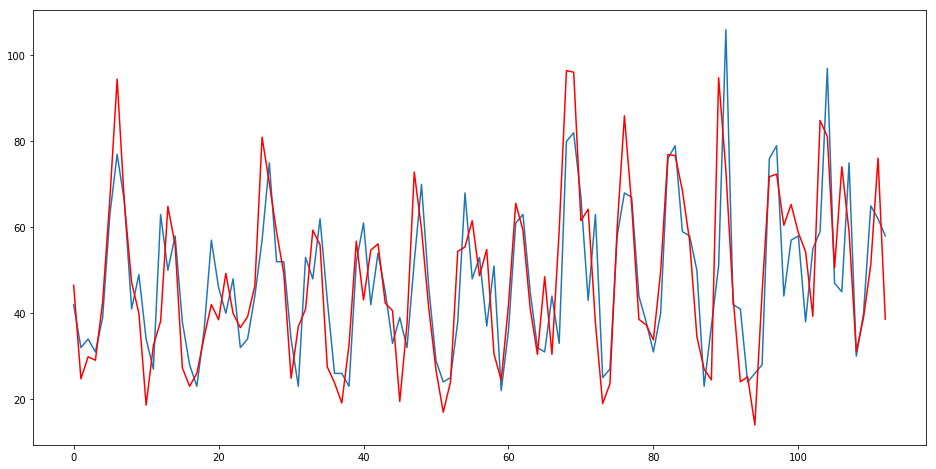

In [307]:
# correct forecasts with a model of forecast residual errors 
from statsmodels.tsa.ar_model import AR 

# split into train and test sets 
X = ts_df.values
train_size = int(len(X) * 0.80) 
train, test = X[1:train_size], X[train_size:] 
train_X, train_y = train[:,0], train[:,1] 
test_X, test_y = test[:,0], test[:,1] 

# persistence model on training set 
train_pred = [x for x in train_X] 

# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))] 

# model the training set residuals 
model = AR(train_resid) 
model_fit = model.fit() 
window = model_fit.k_ar 
coef = model_fit.params 

# walk forward over time steps in test 
history = train_resid[len(train_resid)-window:] 
history = [history[i] for i in range(len(history))] 
predictions = list() 

for t in range(len(test_y)): 
    # persistence 
    yhat = test_X[t] 
    error = test_y[t] - yhat 
    # predict error 
    length = len(history) 
    lag = [history[i] for i in range(length-window,length)] 
    pred_error = coef[0] 
    for d in range(window): 
        pred_error += coef[d+1] * lag[window-d-1] 
        
    # correct the prediction 
    yhat = yhat + pred_error 
    predictions.append(yhat) 
    history.append(error) 
#     print('predicted=%f, expected=%f' % (yhat, test_y[t])) 
    
# error 
rmse = sqrt(mean_squared_error(test_y, predictions)) 
print('Test RMSE: %.3f' % rmse)

plt.figure(figsize = (16, 8))
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

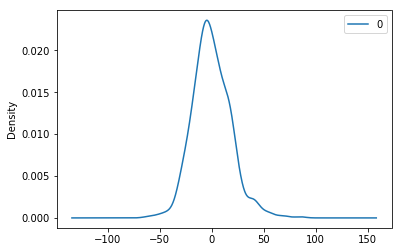

In [313]:
# fit an ARIMA model and plot residual errors
# fit model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts, order=(5, 1,0))
model_fit = model.fit(disp=0)

# summary of fit model
# print(model_fit.summary())

# density plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
# print(residuals.describe())

Test RMSE: 13.894


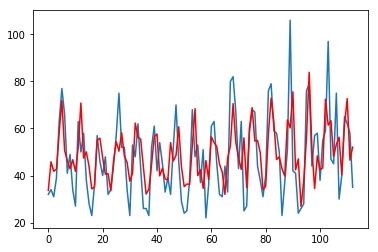

In [332]:
# evaluate an ARIMA model using a walk-forward validation
# split into train and test sets
X = ts_df['t+1'].values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10, 0, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

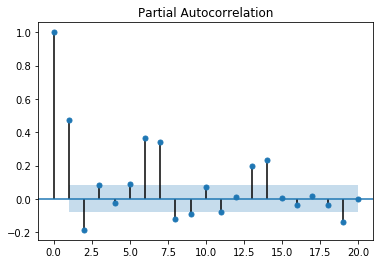

In [329]:
from statsmodels.graphics.tsaplots import plot_pacf 
plot_pacf(ts, lags=20) 
plt.show()

In [639]:
import statsmodels.tsa.api as smt
mod = smt.SARIMAX(ts, trend='c', order=(1, 1, 1))
res = mod.fit()


def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

tsplot(res.resid[2:], lags=40);

ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.

In [3]:
import lightgbm